In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-19 00:36:26.430950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 00:36:26.485671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 00:36:26.485811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# **Importing Important Libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
import pathlib 
from shutil import copyfile
import os 
import PIL
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.regularizers import l2

2023-05-19 00:36:18.744674: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-19 00:36:18.845087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 00:36:19.423271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Visualization**

In [223]:
def plot(history, val_exist=True):
    acc = history.history['accuracy']

    if val_exist:
        val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    if val_exist:
        val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    if val_exist:
        plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    # plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    if val_exist:
        plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    # plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# **Loading and Preprocessing Data**

In [291]:
def ds_generator(path, batch_size=16, to_1_hot=False, shuffle=True, image_height=224, image_width=224, seed=123, num_classes=3):
    dir = pathlib.Path(path)


    ds = tf.keras.utils.image_dataset_from_directory(
        dir,
        seed=seed,
        image_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=shuffle)
    
    if to_1_hot:
        # Create a function to convert labels to one-hot encoding
        num_classes = num_classes
        def to_one_hot(x, y):
            num_classes = 3
            y_one_hot = tf.one_hot(y, num_classes)
            return x, y_one_hot
        ds = ds.map(to_one_hot)
    
    return ds

In [279]:
data_dir = pathlib.Path("real")
print(len(list(data_dir.glob("*/*"))))


10


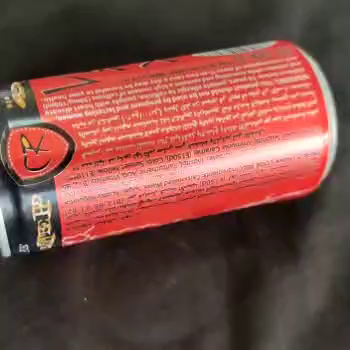

In [ ]:
trash = list(data_dir.glob('Can/*'))
PIL.Image.open(str(trash[0]))

In [190]:
batch_size = 1
image_height = 224
image_width = 224

In [194]:
1/1140

0.0008771929824561404

In [290]:
del train_ds

In [281]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  # validation_split=0.0008771929824561404,
  # subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 10 files belonging to 4 classes.


In [250]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.0008771929824561404,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 10 files belonging to 4 classes.
Using 0 files for validation.


In [260]:
# Evaluating on a new dataset from the internet
# paper and plastic from  https://www.kaggle.com/datasets/arthurcen/waste-images-from-sushi-restaurant
# can from https://universe.roboflow.com/dataset-t7hz7/cans-fdboa/dataset/1
test_dir = pathlib.Path("dcrpi-b")


test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_height, image_width),
  batch_size=1,
  shuffle=False)


Found 231 files belonging to 4 classes.


In [ ]:
# Don't run this cell if you are testing on a new dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 146


In [ ]:
#Classes as inferred
class_names = train_ds.class_names
print(class_names)

['Can', 'General Waste', 'Paper', 'Plastic']


2023-05-16 02:23:18.540263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [52856]
	 [[{{node Placeholder/_4}}]]
2023-05-16 02:23:18.540473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [52856]
	 [[{{node Placeholder/_4}}]]


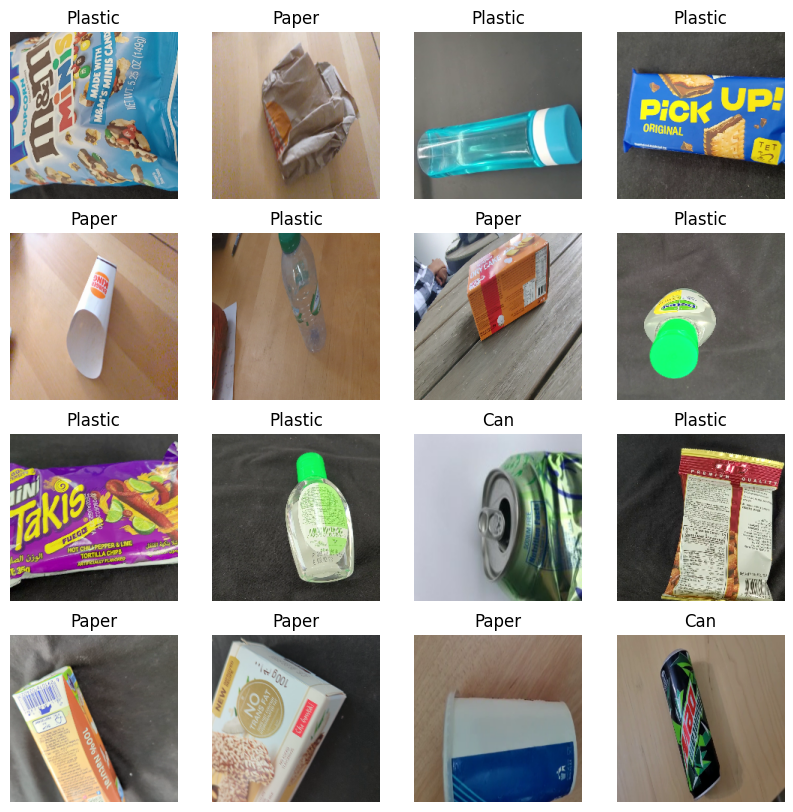

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-05-19 00:37:26.344870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [52843]
	 [[{{node Placeholder/_4}}]]
2023-05-19 00:37:26.345145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [52843]
	 [[{{node Placeholder/_0}}]]


(32, 224, 224, 3)
(32,)


# **Configure Dataset Performance**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds= test_ds.prefetch(buffer_size=AUTOTUNE)

# **Data Augmentation**

In [ ]:
def image_augmentation(inputs):
    data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(factor=0.15),
  tf.keras.layers.RandomTranslation(height_factor=0.1,width_factor=0.1),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(factor=0.1)
])(inputs)
    return data_augmentation

In [ ]:
def preprocess_image_input(input_images):
    #input_images = tf.keras.layers.Resizing(height=224,width=224)(input_images)
    output_ims = preprocess_input(input_images)
    return output_ims



In [ ]:
def feature_extractor(inputs):
    base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
    )(inputs)
    base_model.trainable = False
    #Don't train existing weights
    return base_model
def classifier(inputs):
    #x = layers.MaxPooling2D(2,2)(inputs)
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(256,activation='relu')(x)
    x = layers.Dense(256,activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(4,name='output')(x)
    return x 

def final_model(inputs):
    x = image_augmentation(inputs)
    x = preprocess_image_input(x)
    x = feature_extractor(x)
    x = classifier(x)
    return x

def compile_model():
    inputs = tf.keras.Input(shape=(224,224,3),name="input")
    classification_outputs = final_model(inputs)
    model = tf.keras.Model(inputs=inputs,outputs=classification_outputs)
    model.compile(optimizer=Adam(1e-3),loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    return model

model = compile_model()
model.summary()



In [412]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
#model_checkpoint = ModelCheckpoint('ResnetModels/resnet4classes_best_model.h5', save_best_only=False)
tensorboard_callback = TensorBoard(log_dir='./ResNet50_4_17_1.1')


model_checkpoint = ModelCheckpoint( filepath = 'Checkpoint/Resnet50_3_17_1.5/'+'{epoch:02d}.h5',
    save_weights_only=False,
    save_best_only=False,
    save_freq='epoch',
    verbose=1)


In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=[tensorboard_callback])

Epoch 1/30


2023-05-19 00:51:19.448570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [52843]
	 [[{{node Placeholder/_0}}]]
2023-05-19 00:51:19.448752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [52843]
	 [[{{node Placeholder/_0}}]]
2023-05-19 00:51:28.713140: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x35bc2d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-19 00:51:28.713160: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce

1652/1652 [==============================] - ETA: 0s - loss: 0.5080 - accuracy: 0.8003

2023-05-19 00:56:53.298782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13210]
	 [[{{node Placeholder/_4}}]]
2023-05-19 00:56:53.299015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13210]
	 [[{{node Placeholder/_4}}]]


1652/1652 [==============================] - 359s 202ms/step - loss: 0.5080 - accuracy: 0.8003 - val_loss: 0.4504 - val_accuracy: 0.8647
Epoch 2/30
1652/1652 [==============================] - 336s 203ms/step - loss: 0.2051 - accuracy: 0.9277 - val_loss: 0.1718 - val_accuracy: 0.9411
Epoch 3/30
1652/1652 [==============================] - 337s 204ms/step - loss: 0.1298 - accuracy: 0.9558 - val_loss: 0.3151 - val_accuracy: 0.8994
Epoch 4/30
1652/1652 [==============================] - 337s 204ms/step - loss: 0.0940 - accuracy: 0.9685 - val_loss: 0.0965 - val_accuracy: 0.9731
Epoch 5/30
1652/1652 [==============================] - 337s 203ms/step - loss: 0.0790 - accuracy: 0.9738 - val_loss: 0.2263 - val_accuracy: 0.9315
Epoch 6/30
1652/1652 [==============================] - 337s 204ms/step - loss: 0.0648 - accuracy: 0.9784 - val_loss: 0.1552 - val_accuracy: 0.9517
Epoch 7/30
1652/1652 [==============================] - 338s 204ms/step - loss: 0.0513 - accuracy: 0.9838 - val_loss: 0.068

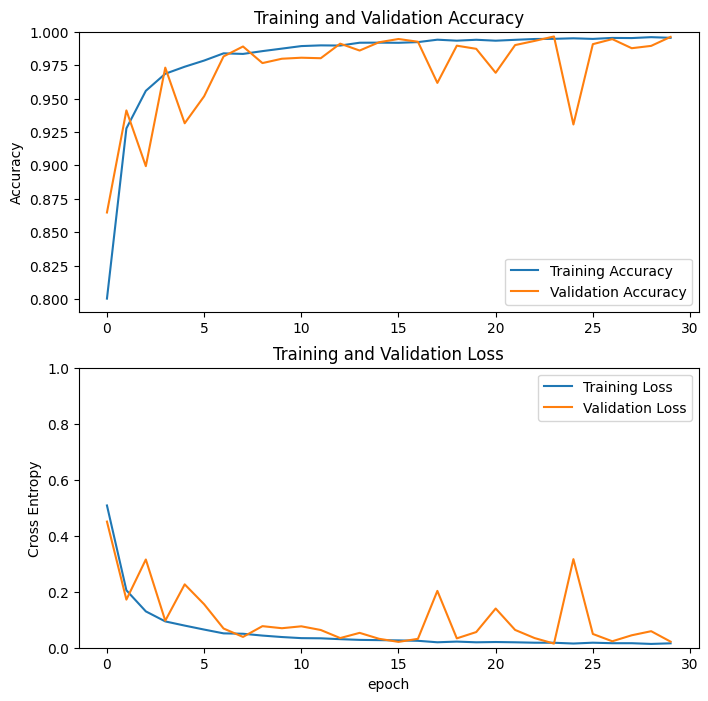

In [ ]:
#plot history to see learning curve - just transfer learning
plot(history)

In [ ]:
%tensorboard --logdir VGG19-Logs

UsageError: Line magic function `%tensorboard` not found.


# **Fine-tuning**

In [ ]:
def fine_tune(model):
    for layer in model.layers[165:]:
        if 'conv' in layer.name:
                layer.kernel_regularizer = l2(0.01)
        layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model


In [ ]:
model = fine_tune(model)
epochs = 30  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1)

Epoch 1/30
1652/1652 [==============================] - 350s 199ms/step - loss: 0.0453 - accuracy: 0.9984 - val_loss: 0.0232 - val_accuracy: 0.9971
Epoch 2/30
1652/1652 [==============================] - 333s 201ms/step - loss: 0.0426 - accuracy: 0.9981 - val_loss: 0.0187 - val_accuracy: 0.9970
Epoch 3/30
1652/1652 [==============================] - 334s 202ms/step - loss: 0.0457 - accuracy: 0.9983 - val_loss: 0.0199 - val_accuracy: 0.9973
Epoch 4/30
1652/1652 [==============================] - 335s 202ms/step - loss: 0.0408 - accuracy: 0.9983 - val_loss: 0.0216 - val_accuracy: 0.9974
Epoch 5/30
1652/1652 [==============================] - 334s 202ms/step - loss: 0.0401 - accuracy: 0.9988 - val_loss: 0.0216 - val_accuracy: 0.9969
Epoch 6/30
1652/1652 [==============================] - 334s 202ms/step - loss: 0.0400 - accuracy: 0.9985 - val_loss: 0.0209 - val_accuracy: 0.9971
Epoch 7/30
1652/1652 [==============================] - 335s 202ms/step - loss: 0.0388 - accuracy: 0.9983 - val_

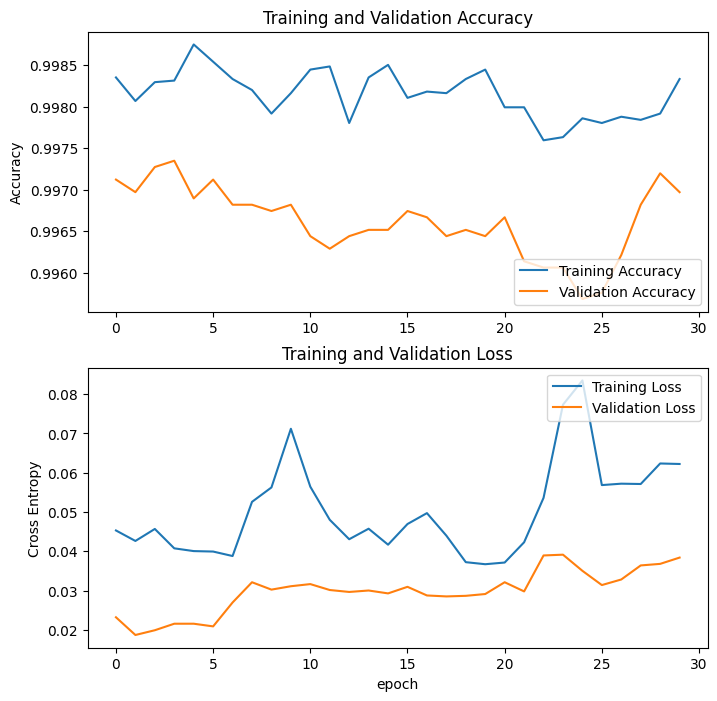

In [ ]:
plot(hist)

In [ ]:
#code for saving model 
model.save("VGG19Models/RestNet50-STBv20.2")

2023-05-19 14:54:54.906701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_rotation_input' with dtype float and shape [?,224,224,3]
	 [[{{node random_rotation_input}}]]
2023-05-19 14:54:55.015505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,224,224,3]
	 [[{{node inputs}}]]
2023-05-19 14:54:55.029374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_rotation_input' with dtype float

INFO:tensorflow:Assets written to: VGG19Models/RestNet50-STBv20.2/assets


INFO:tensorflow:Assets written to: VGG19Models/RestNet50-STBv20.2/assets


# **Evaluation and Prediction**

In [ ]:
# No need to do this if u just trained the model from above
# load trained model

model = tf.keras.models.load_model("Models/ResNet50-STBv1.0_17/")
new_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
new_layer = tf.keras.layers.Dense(4, activation='softmax')
output = new_layer(new_model.output)
new_model = tf.keras.Model(inputs=new_model.input, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
new_model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [ ]:
test_model = tf.keras.models.load_model("ResnetModels/resnet4classes_best_model.h5")

In [ ]:
loss, accuracy = test_model.evaluate(test_ds)

2023-05-20 01:53:49.417074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [232]
	 [[{{node Placeholder/_4}}]]
2023-05-20 01:53:49.417276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [232]
	 [[{{node Placeholder/_4}}]]


232/232 [==============================] - 2s 5ms/step - loss: 2.7504 - accuracy: 0.5043


In [ ]:
epochs = 5  # @param {type: "slider", min:8, max:50}
hist = new_model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1,callbacks=[model_checkpoint,tensorboard_callback])

Epoch 1/5
1652/1652 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9984
Epoch 1: saving model to ResnetModels/01.h5
1652/1652 [==============================] - 286s 173ms/step - loss: 0.0044 - accuracy: 0.9984 - val_loss: 0.0146 - val_accuracy: 0.9971
Epoch 2/5
1652/1652 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9983
Epoch 2: saving model to ResnetModels/02.h5
1652/1652 [==============================] - 289s 175ms/step - loss: 0.0044 - accuracy: 0.9983 - val_loss: 0.0153 - val_accuracy: 0.9966
Epoch 3/5
1652/1652 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9982
Epoch 3: saving model to ResnetModels/03.h5
1652/1652 [==============================] - 290s 175ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0131 - val_accuracy: 0.9969
Epoch 4/5
1652/1652 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9986
Epoch 4: saving model to ResnetModels/04.h5
1652/1652 [==============

In [ ]:
model1 = tf.keras.models.load_model("ResnetModels/05.h5")

In [205]:
hist = model1.fit(train_ds, epochs=70, verbose=1,callbacks=[model_checkpoint,tensorboard_callback])

Epoch 1/70
1138/1139 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9851
Epoch 1: saving model to Checkpoint/Resnet50_4_17_1.1/01.h5
1139/1139 [==============================] - 15s 13ms/step - loss: 0.0418 - accuracy: 0.9851
Epoch 2/70
1139/1139 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9833
Epoch 2: saving model to Checkpoint/Resnet50_4_17_1.1/02.h5
1139/1139 [==============================] - 15s 13ms/step - loss: 0.0543 - accuracy: 0.9833
Epoch 3/70
1138/1139 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9903
Epoch 3: saving model to Checkpoint/Resnet50_4_17_1.1/03.h5
1139/1139 [==============================] - 15s 13ms/step - loss: 0.0275 - accuracy: 0.9903
Epoch 4/70
1139/1139 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9895
Epoch 4: saving model to Checkpoint/Resnet50_4_17_1.1/04.h5
1139/1139 [==============================] - 15s 13ms/step - loss: 0.0366 - accuracy: 0.9

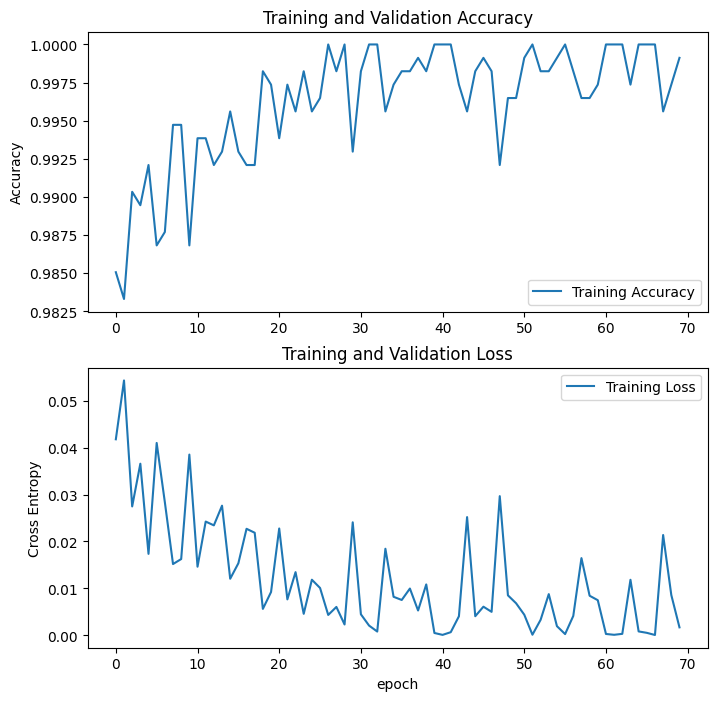

In [224]:
plot(hist, val_exist=False)

In [417]:
train_ds = ds_generator("dcrpi-b-augm", batch_size=1, to_1_hot=False, shuffle=False, image_height=224, image_width=224, seed=123, num_classes=4)

Found 1150 files belonging to 4 classes.


In [ ]:
test_ds = ds_generator("real", batch_size=16, to_1_hot=False, shuffle=True, image_height=224, image_width=224, seed=123, num_classes=4)

In [431]:
model20 = keras.models.load_model("Models/ResNet50-STBv1.0_17_4_1.4")

In [360]:
del tflite_model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model20.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [419]:
train_ds.class_names

['can', 'general', 'paper', 'plastic']

In [414]:
hist3 = model3.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=[model_checkpoint])

Epoch 1/30


2023-05-20 20:32:11.861366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [803]
	 [[{{node Placeholder/_4}}]]
2023-05-20 20:32:11.861601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [803]
	 [[{{node Placeholder/_4}}]]


800/803 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.9925
Epoch 1: saving model to Checkpoint/Resnet50_3_17_1.5/01.h5
803/803 [==============================] - 14s 14ms/step - loss: 0.1112 - accuracy: 0.9925 - val_loss: 13.1960 - val_accuracy: 0.0000e+00
Epoch 2/30
800/803 [============================>.] - ETA: 0s - loss: 0.1689 - accuracy: 0.9638
Epoch 2: saving model to Checkpoint/Resnet50_3_17_1.5/02.h5
803/803 [==============================] - 11s 13ms/step - loss: 0.1683 - accuracy: 0.9639 - val_loss: 13.4962 - val_accuracy: 0.0000e+00
Epoch 3/30
801/803 [============================>.] - ETA: 0s - loss: 0.1724 - accuracy: 0.9576
Epoch 3: saving model to Checkpoint/Resnet50_3_17_1.5/03.h5
803/803 [==============================] - 10s 13ms/step - loss: 0.1719 - accuracy: 0.9577 - val_loss: 21.9264 - val_accuracy: 0.0000e+00
Epoch 4/30
801/803 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.9388
Epoch 4: saving model to Checkpoi

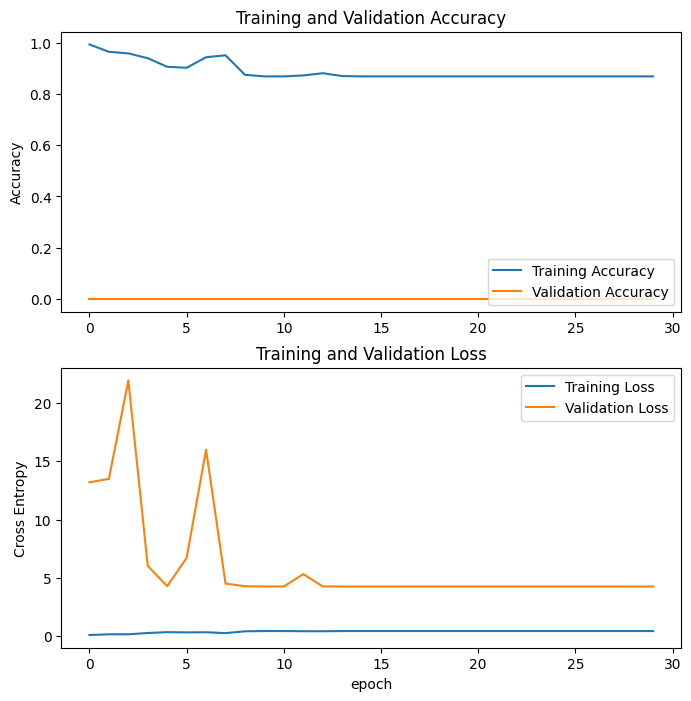

In [415]:
plot(hist3)

In [373]:
model17 = keras.models.load_model("Checkpoint/Resnet50_4_17_1.4/17.h5")

In [432]:
loss, accuracy = model20.evaluate(train_ds)

1150/1150 [==============================] - 7s 6ms/step - loss: 2.7911 - accuracy: 0.6322


In [433]:
preds = model20.predict(train_ds)
# preds

1150/1150 [==============================] - 5s 4ms/step


In [422]:
y_preds = np.argmax(preds, axis=1)

Y = []
for images, labels in train_ds:
    for label in labels:
        Y.append(label)

y_test = np.array(Y)
y_test

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [409]:
model3 = keras.models.load_model("Models/ResNet50-STBv1.0_17")

In [423]:
cm = tf.math.confusion_matrix(y_test,y_preds,4)
cm 

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 86, 106,   7,   0],
       [  0, 141,   0,   0],
       [ 42, 143, 155,   0],
       [ 30, 373,  15,  52]], dtype=int32)>

In [401]:
y_test = y_test.reshape(62,1)
y_preds = y_preds.reshape(62,1)
y_test.shape,y_preds.shape

((62, 1), (62, 1))

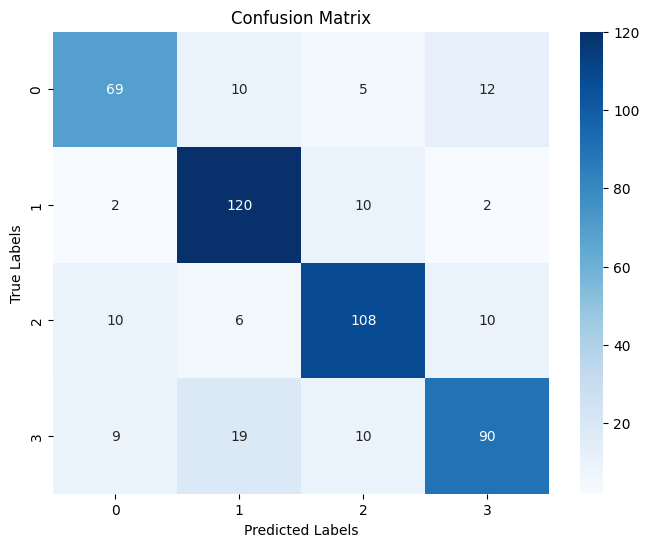

In [443]:
# Example 4x4 list of lists
data = [[69, 10, 5, 12],
        [2, 120, 10, 2],
        [10, 6, 108, 10],
        [9, 19, 10, 90]]

# Convert the list into a numpy array
data = np.array(data)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True, fmt="d", cmap="Blues")

# Set axis labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

/tmp/ipykernel_1997902/1364317635.py:8: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


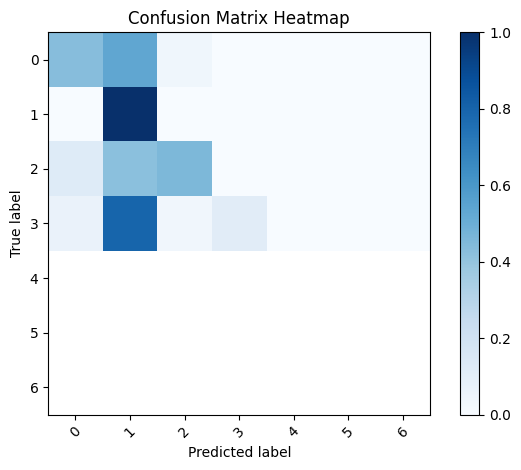

In [444]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_test, y_predictions):
    labels = sorted(list(set(y_test + y_predictions)))
    cm = confusion_matrix(y_test, y_predictions, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix Heatmap")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()

# Example usage

plot_heatmap(y_test, y_preds)
plt.show()


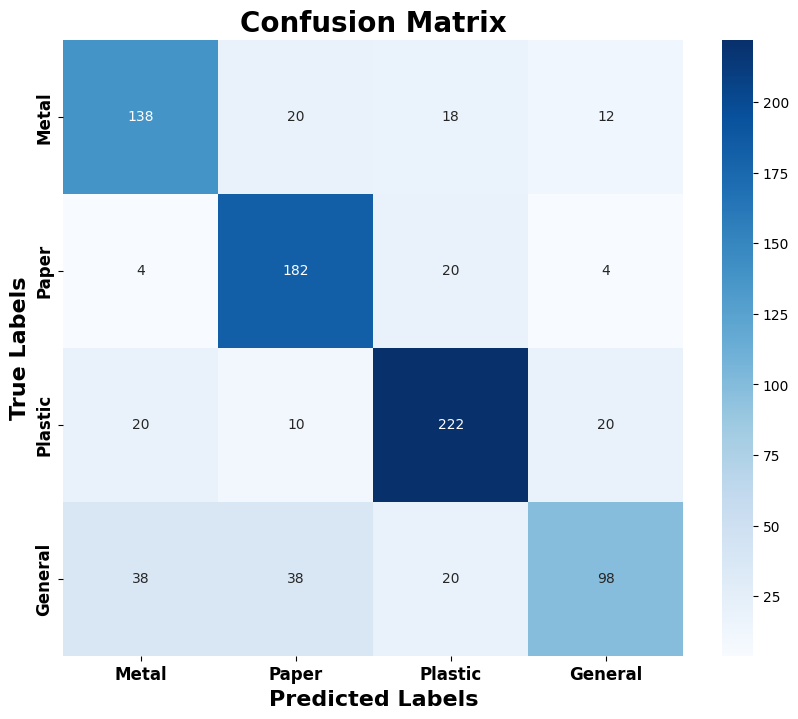

In [467]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your actual and predicted labels, respectively
# Make sure both y_test and y_pred are numpy arrays

# Calculate the confusion matrix
# cm = confusion_matrix(y_test, y_preds)

# Example 4x4 list of lists
data = [[69, 10, 9, 6],
        [2, 91, 10, 2],
        [10, 5, 111, 10],
        [19, 19, 10, 49]]

# Convert the list into a numpy array
cm = np.array(data)*2

# Define the class labels
class_labels = ['Metal', 'Paper', 'Plastic', 'General']  # Modify as per your class names

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

# Customize label properties
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)

# Set axis labels and title
plt.xlabel("Predicted Labels", fontweight='bold', fontsize=16)
plt.ylabel("True Labels", fontweight='bold', fontsize=16)
plt.title("Confusion Matrix", fontweight='bold', fontsize=20)

# Show the plot
plt.show()

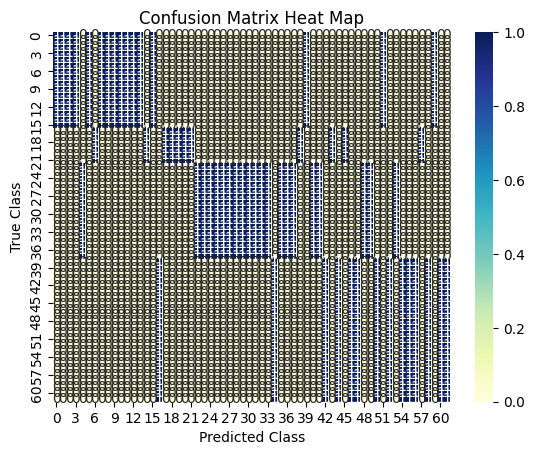

In [404]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example decision and prediction values
decision_values = np.array(y_test)

prediction_values = np.array(preds)

# Calculate the confusion matrix
confusion_matrix = decision_values == np.argmax(prediction_values, axis=1)

# Generate the heat map
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")

# Add labels and title
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix Heat Map')

# Display the plot
plt.show()


In [378]:
# to show misclassified images
def show_images(i_s,images):
    mid = (len(images))**0.5

    nrows = int(np.ceil(mid))
    ncols = int(np.floor(mid))
    class_names = ['c', 'g', 'pa', 'pl']
    print(f"rows {nrows} cols {ncols}")
    plt.figure(figsize=(20, 20))
    # for images, labels in train_ds.take(1):
    for i in range(len(images)):
        ax = plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        A = class_names[y_test[i_s[i]]]
        P = class_names[y_preds[i_s[i]]]
        plt.title(f"P-{P} A-{A}")

        plt.axis("off")

rows 5 cols 4


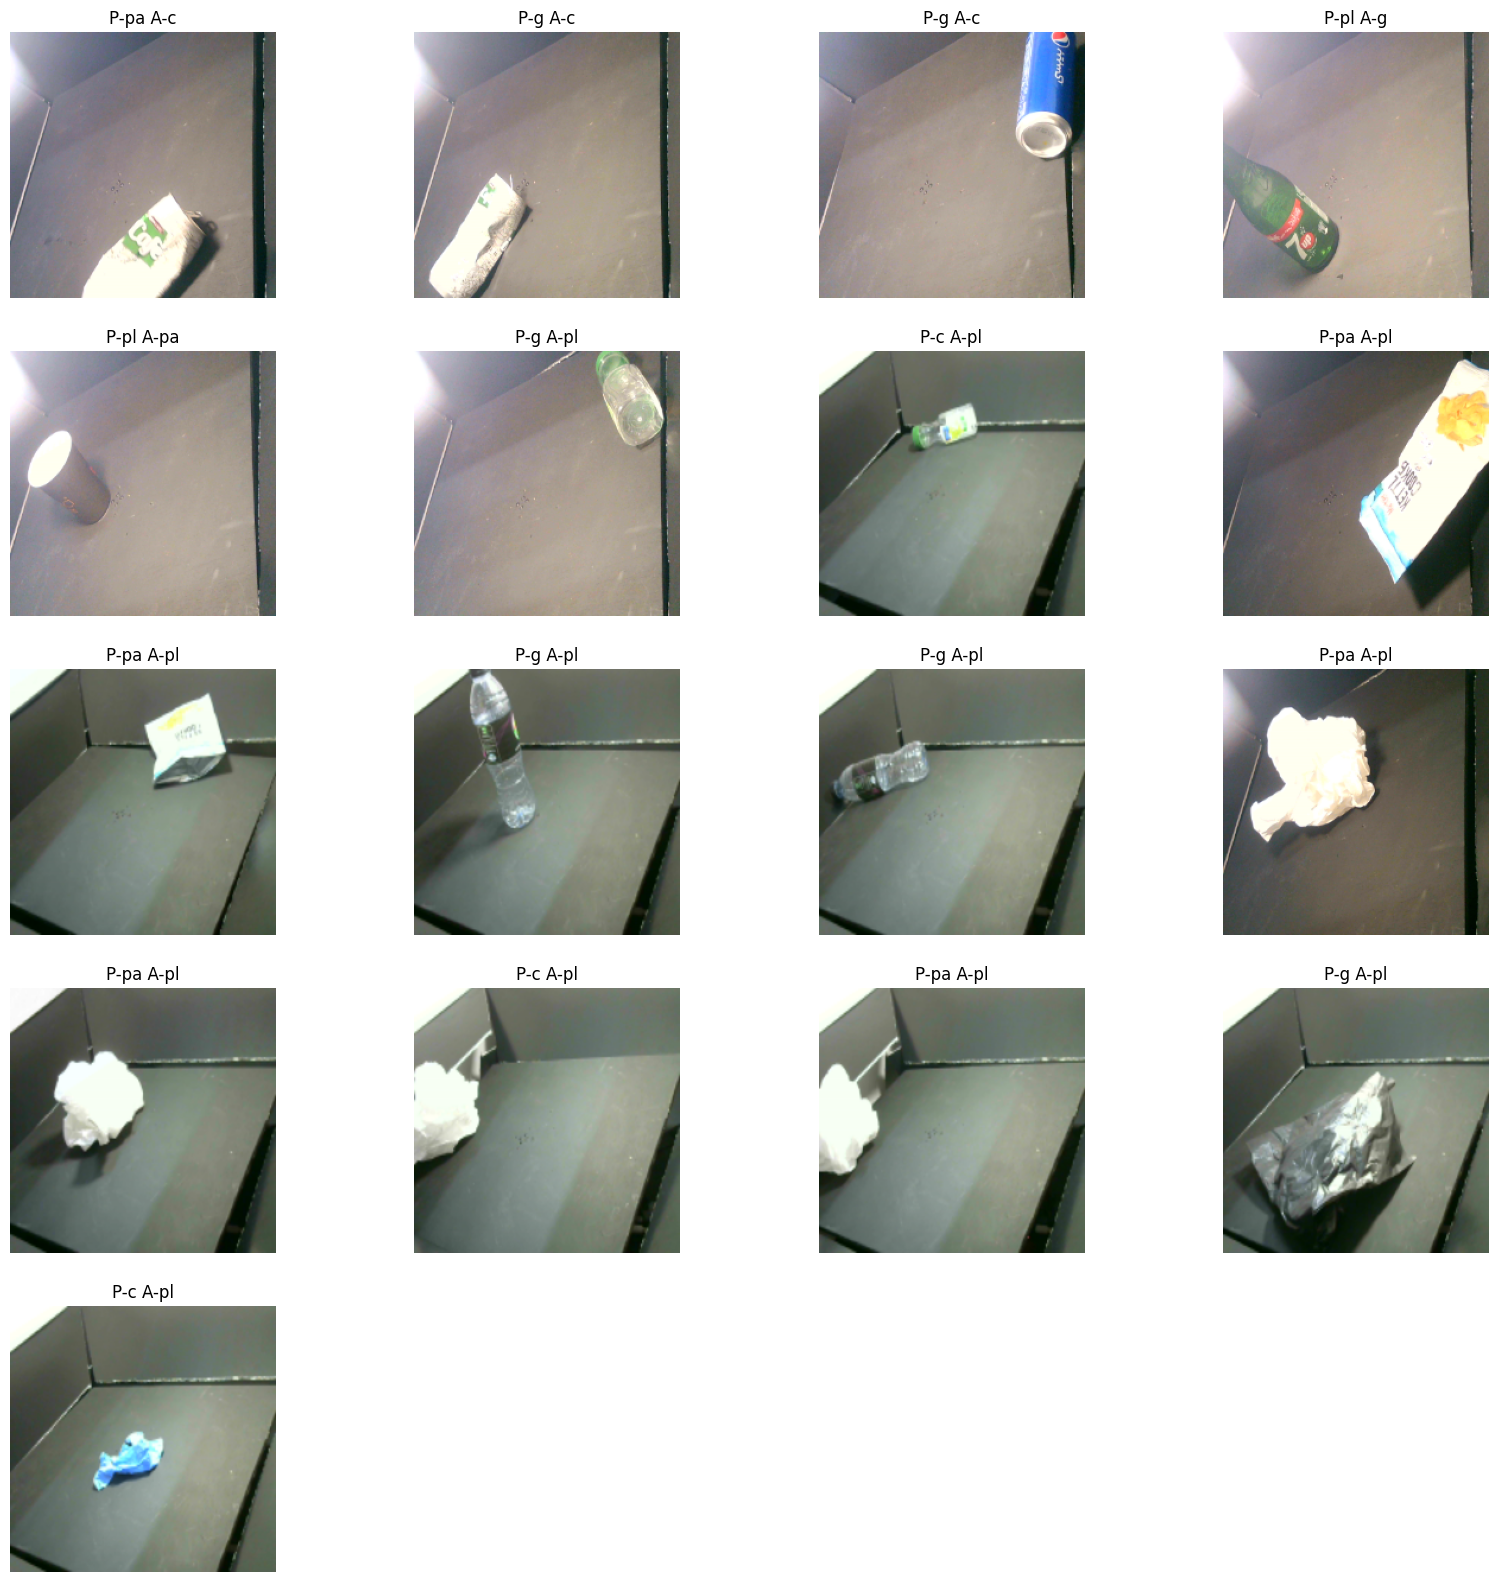

In [381]:
images = []
i_s = []
for i, (image, label) in enumerate(train_ds):
    if y_test[i] != y_preds[i]:
        im = tf.squeeze(image)
        if i==0: 
            print(im.shape)
        images.append(im)
        i_s.append(i)
show_images(i_s,images)

In [ ]:
test = preprocess_input(np.array(test_ds))
loss, accuracy = model.evaluate(test)
print("Test accuracy :",accuracy)

## Saving Model 

In [240]:
model67.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                           

In [239]:
#code for saving model 
model.save("Models/ResNet50-STBv1.0_17_4_1.1")

2023-05-20 11:53:11.083893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,224,224,3]
	 [[{{node random_flip_input}}]]
2023-05-20 11:53:11.160079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,224,224,3]
	 [[{{node inputs}}]]
2023-05-20 11:53:11.167691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [

INFO:tensorflow:Assets written to: Models/ResNet50-STBv1.0_17_4_1.1/assets


INFO:tensorflow:Assets written to: Models/ResNet50-STBv1.0_17_4_1.1/assets


# **Converting The Model to Lite**

In [ ]:
model67.summary()

In [383]:
# Convert the model.
#model = tf.load
converter = tf.lite.TFLiteConverter.from_keras_model(model17)
tflite_model = converter.convert()

# Save the model.
with open('Models/ResNet50-STBv1.0_17_4_1.4.Lite', 'wb') as f:
  f.write(tflite_model)

2023-05-20 17:07:00.254544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,224,224,3]
	 [[{{node random_flip_input}}]]
2023-05-20 17:07:00.303814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,224,224,3]
	 [[{{node inputs}}]]
2023-05-20 17:07:00.313734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [

INFO:tensorflow:Assets written to: /tmp/tmp_95a9wbl/assets


INFO:tensorflow:Assets written to: /tmp/tmp_95a9wbl/assets
2023-05-20 17:07:22.987986: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-20 17:07:22.988009: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-20 17:07:22.988193: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_95a9wbl
2023-05-20 17:07:23.053536: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-20 17:07:23.053567: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_95a9wbl
2023-05-20 17:07:23.226241: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-20 17:07:23.709993: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp_95a9wbl
2023-05-20 17:07:23.877107: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

# Confusion Matrix

In [ ]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))